In [27]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

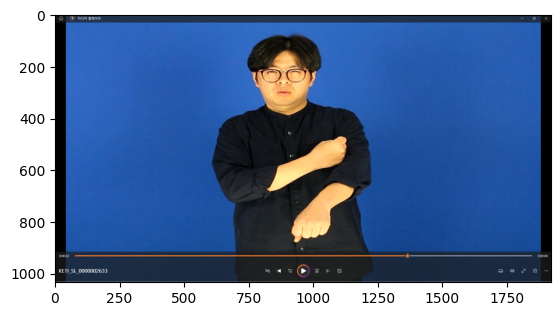

In [28]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("C:/Users/elena/Desktop/dddd.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [33]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# Prepare Data

In [57]:
image = mp.Image.create_from_file("C:/Users/elena/Desktop/dddd.png")

result = detector.detect(image)

In [44]:
print(result)

HandLandmarkerResult(handedness=[[Category(index=0, score=0.9625795483589172, display_name='Left', category_name='Left')], [Category(index=1, score=0.9884921908378601, display_name='Right', category_name='Right')]], hand_landmarks=[[NormalizedLandmark(x=0.5296077132225037, y=0.5502113103866577, z=-1.9988833344086743e-07, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5320110321044922, y=0.49983590841293335, z=0.0012027641059830785, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.546838641166687, y=0.47545114159584045, z=0.0028168312273919582, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5624271035194397, y=0.47664400935173035, z=0.0038899299688637257, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5701788067817688, y=0.4888001084327698, z=0.005536816082894802, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5716667771339417, y=0.4804833233356476, z=0.004382707178592682, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5840504765510559, y=0.465276

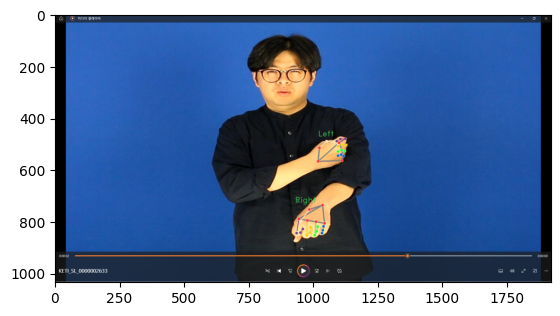

In [58]:
image = cv2.cvtColor(image.numpy_view(), cv2.COLOR_RGB2BGR)
annotated = draw_landmarks_on_image(image, result)
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
plt.imshow(annotated)

In [149]:
def angle(joint, label):
    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
    v = v2 - v1 # [20, 3]
    # Normalize v
    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

    # Get angle using arcos of dot product
    angle = np.arccos(np.einsum('nt,nt->n', # Einstein Summation 표기법으로 다차원 배열의 내적 계산 -> arccos값 구해서 angle에 할당
        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], # einsum: 두 개의 벡터 배열 간의 내적 계산
        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]
    
    angle = np.degrees(angle) # Convert radian to degree

    angle_label = np.array([angle], dtype=np.float32)
    angle_label = np.append(angle_label, label)

    d = np.concatenate([joint.flatten(), angle_label])

    return d

# Video

In [167]:
import re
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

'''
data
  |_  (video folder)
  |_  .xlsx
'''
PATH = "C:/Users/elena/Desktop/data/" # 폴더 경로
video_path = PATH + "0001~3000(영상)/"
file_name = os.listdir(video_path)

os.makedirs(PATH+'output', exist_ok=True)

for file in file_name:
    file_path = video_path + file
    file_ = re.search(r'\d+', file).group()
    file_ = int(re.sub(r'^0+', '', file_))

    # xlsx에서 영상에 해당하는 label 찾기
    excel = pd.read_excel(PATH + 'KETI-2017-SL-Annotation-v2_1.xlsx')
    label = excel[excel['번호'] == file_]['한국어'].values[0]
    label = str(label)

    full_data = np.empty(shape=(0, 2, 79))
    while cap.isOpened():

        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

        result = detector.detect(mp_image)

        annotated = draw_landmarks_on_image(frame, result)
        final = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

        # out.write(final)

        if len(result.handedness) > 0: # 손이 감지되었을 때
            pair = []
            left_data = []
            right_data = []
            if len(result.handedness) == 2: # 양손 감지
                joint1 = np.zeros((21, 3))
                joint2 = np.zeros((21, 3))

                for idx1, lm1 in enumerate(result.hand_landmarks[0]):
                    joint1[idx1] = [lm1.x, lm1.y, lm1.z]
                for idx2, lm2 in enumerate(result.hand_landmarks[1]):
                    joint2[idx2] = [lm2.x, lm2.y, lm2.z]
                
                data1 = angle(joint1, label)
                data2 = angle(joint2, label)

                if result.handedness[0][0].category_name == "Left":
                    left_data = data1
                    right_data = data2
                else:
                    left_data = data2
                    right_data = data1
            elif len(result.handedness) == 1:
                joint = np.zeros((21, 3))

                for idx, lm in enumerate(result.hand_landmarks[0]):
                    joint[idx] = [lm.x, lm.y, lm.z]
                
                data = angle(joint, label)
                empty = np.zeros((78,))
                empty = np.append(empty, label)

                if result.handedness[0][0].category_name == "Left":
                    left_data = data
                    right_data = empty
                else:
                    left_data = empty
                    right_data = data
            
            pair = np.array([left_data, right_data])
            
            full_data = np.vstack((full_data, [pair]))

    np.save(PATH+'output/'+str(file_)+'.npy', full_data)

    cap.release()
    cv2.destroyAllWindows()


[['0.33609554171562195' '0.9310166835784912' '-1.6676455771857945e-08'
  '0.3608093559741974' '0.9367601871490479' '-0.009619234129786491'
  '0.37980395555496216' '0.966457188129425' '-0.013483071699738503'
  '0.392873615026474' '0.997635006904602' '-0.01540557760745287'
  '0.399356484413147' '1.0206345319747925' '-0.016559548676013947'
  '0.3629224896430969' '1.011141300201416' '-0.007563450373709202'
  '0.37132564187049866' '1.0494896173477173' '-0.010981488041579723'
  '0.3787062168121338' '1.0698493719100952' '-0.014095739461481571'
  '0.38352900743484497' '1.0819857120513916' '-0.0157496128231287'
  '0.3487381935119629' '1.0198981761932373' '-0.003125847550109029'
  '0.35769736766815186' '1.0566178560256958' '-0.0030461261048913'
  '0.36574146151542664' '1.0769178867340088' '-0.003548127133399248'
  '0.37161022424697876' '1.0892362594604492' '-0.00434037484228611'
  '0.33696019649505615' '1.0221110582351685' '0.00032520011882297695'
  '0.34480103850364685' '1.056334137916565' '-0.

# Final